## Housekeeping Settings

In [7]:
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
from scipy.stats import median_abs_deviation, hypergeom
import multiprocessing as mp, celloracle as co

# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

wd = '/ocean/projects/cis240075p/skeshari/igvf/bcell2/male_donor/'
out_path = os.path.join(wd, 'out_data', 'co_analysis_1')
os.makedirs(f"{out_path}/figures", exist_ok=True)
os.makedirs(f"{out_path}/intermediate_data", exist_ok=True)
os.makedirs(f"{out_path}/out_files", exist_ok=True)
os.makedirs(f"{out_path}/scripts", exist_ok=True)
sc.settings.figdir = f"{out_path}/figures"

## Reading the adata with scRNA and loading base GRN for ATAC part

In [8]:
import glob
conditions = ['GC_PB', 'GC_ABC', 'PB_ABC']
path_to_adata = os.path.join(wd, 'out_data','sc_preproc/out_files/male_sc_processed.h5ad')
adata = sc.read_h5ad(path_to_adata)
n_cells_downsample = 30000 # Random downsampling into 30K cells if the anndata object include more than 30 K cells.
if adata.shape[0] > n_cells_downsample:
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123) # Downsample into 30K cells
# CO uses the unscaled mRNA count for the Input of Oracle object.
adata.X = adata.layers["counts"].A.copy()
# Use only highly variable genes for the analysis
adata = adata[:, adata.var.highly_variable]

In [9]:
# read MIRA data
mira_grn = pd.read_csv(f'{wd}/out_data/out_other_methods/ISD/ISD_matrix.chip.tsv', sep='\t', header=0, low_memory=False, index_col=0)
hvf_genes_mira = set(mira_grn.index)
mira_grn.columns = mira_grn.columns.str.split(r'[./]').str[0]
mira_grn = mira_grn.groupby(mira_grn.columns, axis=1).mean()
TFdatabase = pd.read_csv(f'{wd}/in_data_required/human TF database.csv')
tfs = (set(mira_grn.columns).intersection(set(TFdatabase['HGNC symbol']))).union(['CD74'])
mira_grn = mira_grn[tfs]
threshold = np.percentile(mira_grn.values.flatten(), 95)
mira_grn = mira_grn.applymap(lambda x: 1 if x > threshold else 0)
print('Number of genes regulated by TFs:', mira_grn.T.sum(axis=1).mean(), 'on average from ISD matrix')
TF_to_TG_dictionary = {col: mira_grn.index[mira_grn[col] > 0].tolist() for col in mira_grn.columns}
# read CICERO data
cicero_GRN = pd.read_csv(os.path.join(wd, 'out_data', 'out_other_methods/base_GRN_dataframe.csv'))
cicero_GRN = cicero_GRN[cicero_GRN['gene_short_name'].isin(hvf_genes_mira)].drop(columns=['peak_id']).groupby('gene_short_name').count().sort_values(by='gene_short_name',ascending=False)
TF_to_TG_dictionary.update({col: cicero_GRN.index[cicero_GRN[col] != 0].tolist() for col in cicero_GRN.columns if col not in TF_to_TG_dictionary.keys()})
with open(f'{out_path}/intermediate_data/TF_to_TG_dictionary.pkl','wb') as f:
    pickle.dump(TF_to_TG_dictionary, f)

Number of genes regulated by TFs: 215.30011587485515 on average from ISD matrix


In [10]:
import matplotlib.colors as mcolors
hex_codes = [mcolors.CSS4_COLORS[color] for color in adata.uns['leiden_colors']]# Convert color names to hex codes
adata.uns['leiden_colors'] = hex_codes
# adata.uns["sub_cell_type_colors"] = adata.uns["leiden_colors"]

In [11]:
oracle = co.Oracle() # Instantiate Oracle object
oracle.import_anndata_as_raw_count(adata=adata, cluster_column_name="leiden", embedding_name="X_umap") # assigning scRNA (adata) to oracle object
TG_to_TF_dictionary = co.utility.inverse_dictionary(TF_to_TG_dictionary)
oracle.addTFinfo_dictionary(TG_to_TF_dictionary) # assigning scATAC (baseGRN) to oracle object

4142 genes were found in the adata. Note that Celloracle is intended to use around 1000-3000 genes, so the behavior with this number of genes may differ from what is expected.


  0%|          | 0/3955 [00:00<?, ?it/s]

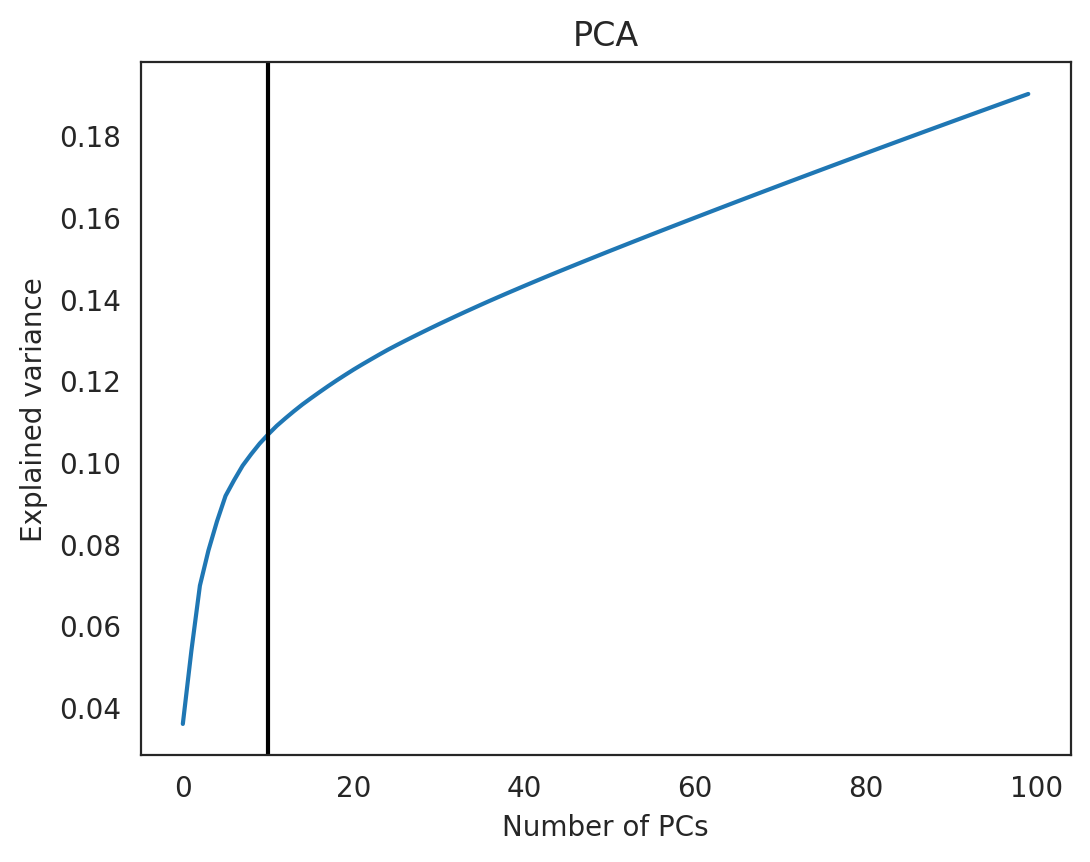

Optimal numbers of PCA dimensions are found to be : 10
Number of cell in the data are :30000
Auto-selected k is :3000


In [12]:
## CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.
# For the KNN imputation, we first need to calculate and select PCs. Perform PCA
oracle.perform_PCA()
# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k");plt.xlabel("Number of PCs");plt.ylabel("Explained variance");plt.title("PCA");plt.show()
print("Optimal numbers of PCA dimensions are found to be :",n_comps)
n_comps = min(n_comps, 50) ## Ceiling the number of PCs to 50

## Performing KNN imputation
n_cell = oracle.adata.shape[0]
print(f"Number of cell in the data are :{n_cell}")
k = 3000 #int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8, b_maxl=k*4, n_jobs=os.cpu_count())
## Save cellOracle data
oracle.to_hdf5(f'{out_path}/intermediate_data/male_data.celloracle.oracle')

## GRN Construction takes time, consider running batch script. Following cell creates `.sh`, `.py` scripts and submits it. 

In [13]:
import subprocess, os
def shell_script_header_cpu(save_path, job_name, n_cpu=24):
    sbatch_script_header_cpu = f"""#!/bin/bash
#SBATCH --job-name="{job_name}"
#SBATCH --output="{save_path}/scripts/{job_name}.log"
#SBATCH -p EM
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task={n_cpu}
#SBATCH -t 0-9:30:00

module load anaconda3/2022.10
source activate celloracle_env

"""
    return sbatch_script_header_cpu

#### Fit GRN for perturbation simulations

In [14]:
job_name = 'oracle_links_fitting'
oracle_links_fitting_py_script = f"""
import celloracle as co, pandas as pd, numpy as np, os
wd = '{wd}'
out_path = os.path.join(f'{{wd}}', 'out_data', 'co_analysis_1')
oracle = co.load_hdf5(f'{{out_path}}/intermediate_data/male_data.celloracle.oracle')
links = oracle.get_links(cluster_name_for_GRN_unit="leiden", alpha=10, verbose_level=10)
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()
links.merged_score.to_csv(f'{{out_path}}/out_files/bayesian_fitted_1_merged_network_scores.csv')
# links.to_hdf5(f'{{out_path}}/intermediate_data/bayesian_fitted_1.celloracle.links')
# Calculate GRN for each population in clustering unit.
links.filter_links() # Getting back to default thresholds (p<0.001 and top 10k) for simulation of GRN -- so that we have enough edges to simulate the GRN
oracle.get_cluster_specific_TFdict_from_Links(links_object=links) #### Runs another round on links.filtered_links to get final links
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

# Save the final links for the KO simulation
links_after_fit = co.Links(name="links_after_fit")
links_after_fit.filtered_links = links.filtered_links #### Just for initialization
for cluster in links.filtered_links.keys():
    cluster_specific_links = oracle.coef_matrix_per_cluster[cluster].stack().reset_index()
    cluster_specific_links.columns = ['source', 'target', 'coef_mean']
    cluster_specific_links = cluster_specific_links[cluster_specific_links ['coef_mean'] != 0].reset_index(drop=True)
    cluster_specific_links['coef_abs'] = np.abs(cluster_specific_links['coef_mean'])
    cluster_specific_links.to_csv(f'{{out_path}}/out_files/cluster_{{cluster}}.csv', index=False)
    links_after_fit.filtered_links[cluster] = cluster_specific_links
links_after_fit.get_network_score()
links_after_fit.merged_score.to_csv(f'{{out_path}}/out_files/ridge_fitted_2_merged_network_scores.csv')
# Saving for KO simulation.
oracle.to_hdf5(f'{{out_path}}/intermediate_data/oracle_fitted.celloracle.oracle')
"""
with open(f'{out_path}/scripts/{job_name}.py', "w", encoding="utf-8") as f:
    f.write(oracle_links_fitting_py_script)

#### Do Perturbation after oracle and links object have been generated

In [15]:
job_name = 'oracle_tf_perturbation'
tf_of_interest = ["BATF","BATF3","BCL6","EGR1","FOS","IKZF1","IRF1","IRF4","IRF8","JUNB","JUND","MEF2A","MEF2C","MYB","NFATC1","NTC1","NFATC2","NFIL3","NFKB1","NFKB2","PAX5","PRDM1","RUNX1","SP3","SPI1","STAT1","STAT5A","TCF12","VDR","XBP1","ZBTB7A","SPIB"]
oracle_tf_perturbation_py_script = f"""
import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
from scipy.stats import median_abs_deviation, hypergeom
import multiprocessing as mp, celloracle as co
wd = '{wd}'
out_path = os.path.join(f'{{wd}}', 'out_data', 'co_analysis_1')

def generating_KO_plots(goi,oracle,scale_simulation=15, n_grid=40, min_mass=3):
    # Plotting
    fig, ax = plt.subplots(1, 3,  figsize=[18, 6])
    oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=1000)
    oracle.calculate_mass_filter(min_mass=min_mass, plot=False)
    oracle.plot_cluster_whole(ax=ax[0], s=10)
    ax[0].set_title(f"Simulated cell identity shift vector: {{goi}} KO")
    oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0], show_background=False)
    oracle.plot_cluster_whole(ax=ax[1], s=10)
    ax[1].set_title(f"Randomized simulation shift vector: {{goi}} KO")
    oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1], show_background=False)
    ax[2].set_title(f"Clustered cell identity")  
    sc.pl.umap(oracle.adata, color=['sub_cell_type'], ax=ax[2], show=False)
    plt.tight_layout()
    plt.savefig(f'{{out_path}}/figures/{{goi}}_KO_simulation.pdf', dpi=600, format="pdf")
    plt.close()
    return None

def perturb_in_out(goi, oracle):
    print(f"Calculating ratio for {{goi}}", flush=True)
    # oracle = co.load_hdf5(f'{{out_path}}/out_files/{{goi}}_perturbation.celloracle.oracle')
    generating_KO_plots(goi, oracle)

    annotation_pooled = {{  "GC":['GC-1','GC-2'],
                            "PB":['PB-2', 'earlyPB'],  
                            "Day3_4":['ActB-4', 'ActB-3'],
                            "Rest" : ['ActB-1', 'Naive', 'ActB-2','earlyActB']}}
    annotation_pooled_reverse = {{}}
    for i in set(oracle.adata.obs.leiden):
        for k in annotation_pooled:
            if i in annotation_pooled[k]:
                annotation_pooled_reverse[i] = k
    oracle.adata.obs["cell_type_pooled"] = [annotation_pooled_reverse[i] for i in oracle.adata.obs.leiden]

    # Defining the type of TF which a TF is
    gc_mean = np.mean(oracle.adata.X[(oracle.adata.obs['cell_type_pooled'] == 'GC'),(oracle.adata.var_names == goi)])
    pb_mean = np.mean(oracle.adata.X[(oracle.adata.obs['cell_type_pooled'] == 'PB'),(oracle.adata.var_names == goi)])
    TF_type = 'GC' if gc_mean > pb_mean else 'PB'

    totalGC_counts = (oracle.adata.obs['cell_type_pooled'] == 'GC').sum()
    totalPB_counts = (oracle.adata.obs['cell_type_pooled'] == 'PB').sum()
    total34_counts = (oracle.adata.obs['cell_type_pooled'] == 'Day3_4').sum()

    transition_matrix = oracle.transition_prob
    # transition_matrix = oracle.transition_prob - (oracle.embedding_knn.A/ oracle.embedding_knn.sum(1).A.T)
    transition_matrix = abs(transition_matrix[oracle.adata.obs['cell_type_pooled'].isin(['GC', 'PB', 'Day3_4']),:])
    row_labels = oracle.adata.obs.loc[oracle.adata.obs['cell_type_pooled'].isin(['GC', 'PB', 'Day3_4']), 'cell_type_pooled']
    col_labels = oracle.adata.obs['cell_type_pooled']
    tm_df = pd.DataFrame(transition_matrix, index=row_labels, columns=col_labels)
    max_prob = tm_df.idxmax(axis=1).reset_index()

    del transition_matrix, tm_df, oracle # Release memory for oom error
    max_prob = max_prob[max_prob['cell_type_pooled']!=max_prob[0]].groupby('cell_type_pooled').agg(lambda x: x.value_counts().to_dict())

    gc_in = max_prob.loc[['Day3_4', 'PB'],0].apply(lambda x: x['GC'] if 'GC' in x.keys() else 0).sum()
    pb_in = max_prob.loc[['Day3_4', 'GC'],0].apply(lambda x: x['PB'] if 'PB' in x.keys() else 0).sum()
    gc_out = sum(max_prob.loc['GC'][0].values())
    pb_out = sum(max_prob.loc['PB'][0].values())
    finalGC_counts = totalGC_counts - gc_out + gc_in
    finalPB_counts = totalPB_counts - pb_out + pb_in
    result = [goi, TF_type, totalGC_counts, totalPB_counts, total34_counts, finalGC_counts, finalPB_counts,gc_in, pb_in, gc_out, pb_out]
    with open(f'{{out_path}}/out_files/{{goi}}_perturbation_result.txt', 'w') as f:
        f.write(f"{{result}}")
    return None

def ko_simulation(goi, cluster_column_name="cell_type"):
    try:
        oracle = co.load_hdf5(f'{{out_path}}/intermediate_data/oracle_fitted.celloracle.oracle')
        # Enter perturbation conditions to simulate signal propagation after the perturbation.
        print(f'Simulating perturbation for {{goi}}', flush=True)
        oracle.simulate_shift(perturb_condition={{goi: 0.0}},n_propagation=2) # If kernal crashes increase the memory limit of jupyter notebook
        print(f'Estimating transition probability for {{goi}}', flush=True)
        oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1) # Get transition probability
        print(f'Calculating embedding for {{goi}}', flush=True)
        oracle.calculate_embedding_shift(sigma_corr=0.05) # Calculate embedding
        print(f'Saving perturbed data for {{goi}}', flush=True)
        oracle.to_hdf5(f'{{out_path}}/out_files/{{goi}}_perturbation.celloracle.oracle')
        print(f'Saving figures for {{goi}}', flush=True)
        perturb_in_out(goi,oracle)
    except Exception as e:
        print(f'Process {{mp.current_process().name}} failed for gene {{goi}} with error {{e}}', flush=True)
    return None


if __name__ == '__main__':
    tf_of_interest = {tf_of_interest}
    skipped = []
    # for goi in tf_of_interest:
    #     if os.path.exists(f'{{out_path}}/out_files/{{goi}}_perturbation.celloracle.oracle'):
    #         print(f'{{goi}} already simulated. Skipping.')
    #         skipped.append(goi)
    #         continue
    tf_of_interest = set(tf_of_interest) - set(skipped)
    with mp.Pool(processes=8) as pool:
        tasks = [pool.apply_async(ko_simulation, args=(tf,)) for tf in tf_of_interest]
        for task in tasks:
            try:
                result = task.get()  # Specify timeout according to needs
                print(f'Task completed: {{task}}')
            except Exception as e:
                print(f'Task failed: {{e}}')
"""
with open(f'{out_path}/scripts/{job_name}.py', "w", encoding="utf-8") as f:
    f.write(oracle_tf_perturbation_py_script)

In [16]:
job_name = 'combined_run'
with open(f'{out_path}/scripts/{job_name}.sh', "w", encoding="utf-8") as f:
    f.write(shell_script_header_cpu(save_path = out_path, job_name = job_name))
    f.write(f"python {out_path}/scripts/oracle_links_fitting.py \n")
    f.write(f"echo 'Oracle links fitting completed' \n")
    f.write(f"python {out_path}/scripts/oracle_tf_perturbation.py")

subprocess.run(["sbatch", f'{out_path}/scripts/{job_name}.sh'])
print(f"Submitted {job_name}.sh")

Submitted batch job 27622801
Submitted combined_run.sh


#### Plotting the correlation

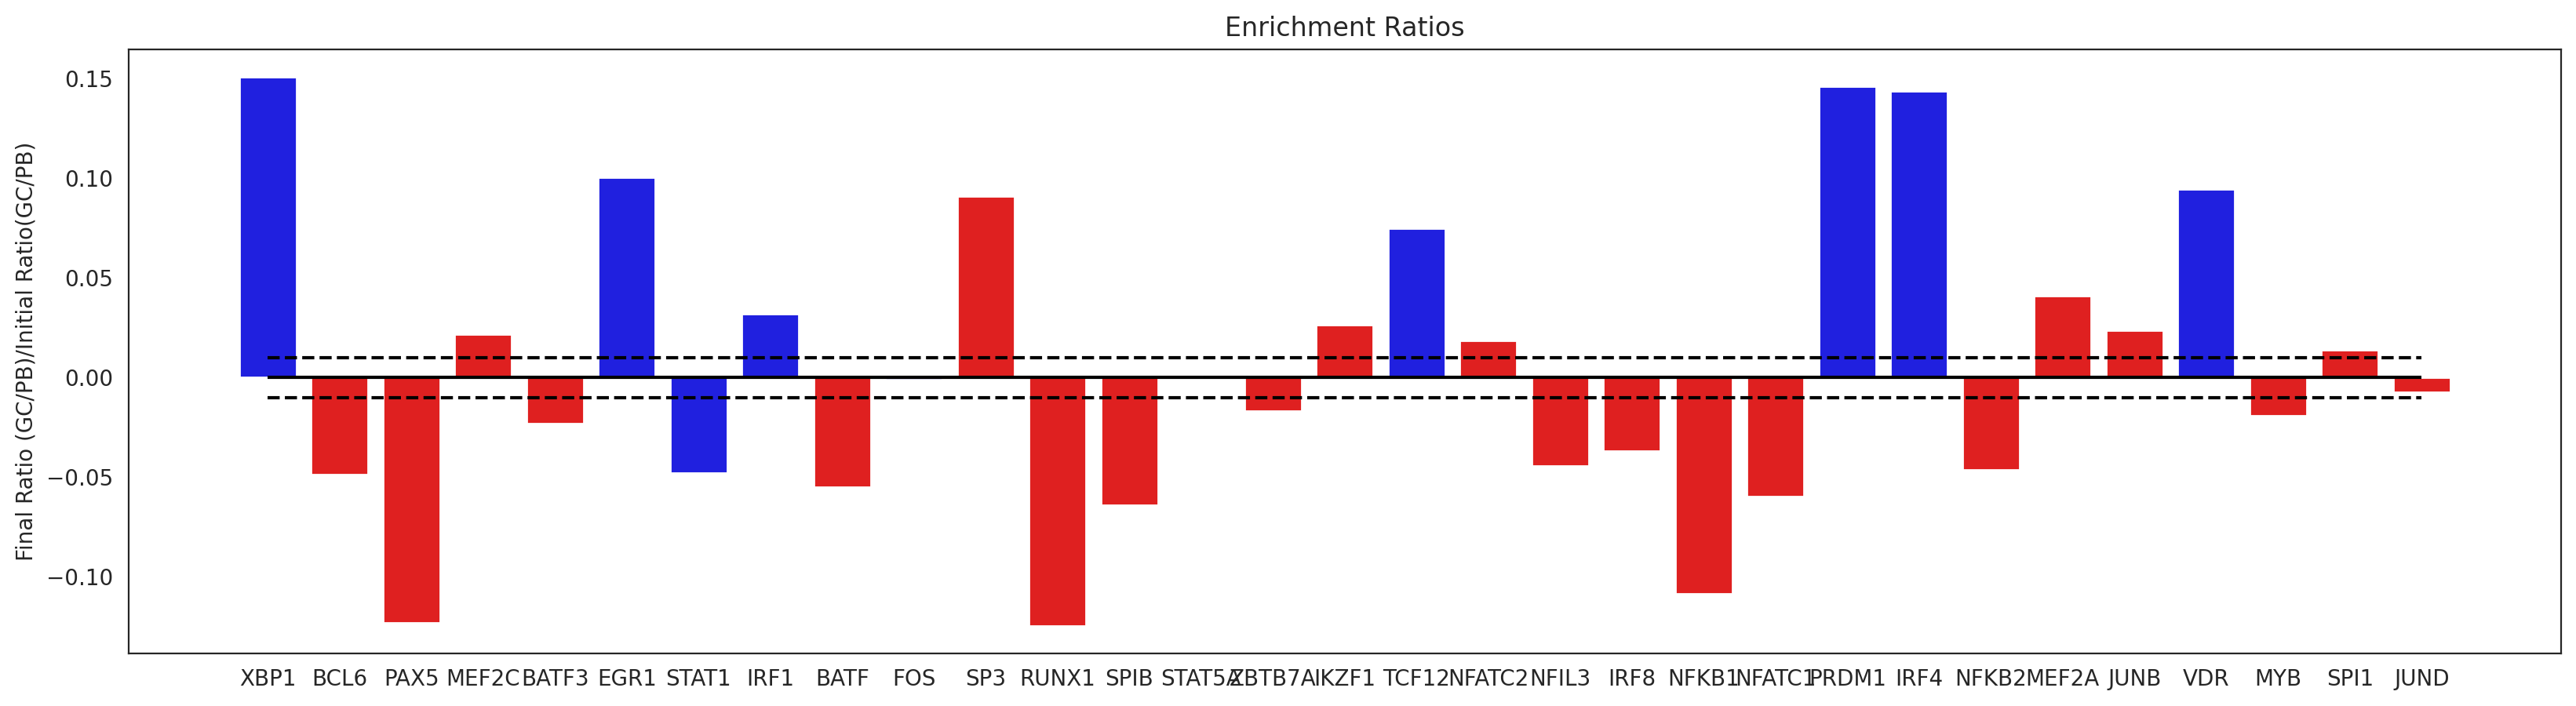

In [2]:
import glob
combined_dict = {}
for file in glob.glob(f'{out_path}/out_files/*_perturbation_result.txt'):
    with open(file, 'r') as f:
        entry = eval(f.read())
        combined_dict[entry[0]] = entry[1:]
x,y = [],[]
colors=[]
for tf in combined_dict.keys():
    x.append(tf)
    # y.append(np.log2(((combined_dict[tf][1]-combined_dict[tf][i+3])/(combined_dict[tf][2]-combined_dict[tf][i+4]))/(combined_dict[tf][1]/combined_dict[tf][2])))
    y.append(np.log2(((combined_dict[tf][4]/combined_dict[tf][5])/(combined_dict[tf][1]/combined_dict[tf][2]))))
    colors.append('r' if combined_dict[tf][0] == 'GC' else 'b')
    pd.DataFrame({'TF':x, 'Ratio':y}).to_csv(f"{out_path}/out_files/ratio_enrichment.csv", index=False)

plt.figure(figsize=(20,5))
plt.title('Enrichment Ratios')
sns.barplot(x=x, y=y, palette=colors)
plt.hlines(y=0.01, xmin=0, xmax=len(x)-1, colors='k', linestyles='dashed')
plt.hlines(y=0.00, xmin=0, xmax=len(x)-1, colors='k')
plt.hlines(y=-0.01, xmin=0, xmax=len(x)-1, colors='k', linestyles='dashed')
plt.ylabel('Final Ratio (GC/PB)/Initial Ratio(GC/PB)')
plt.savefig(f"{out_path}/figures/ratio_enrichment.pdf", dpi=600, format="pdf")

# ROUGH BELOW 

In [ ]:
# # If you want to run in the notebook, you can run the following code. Bad idea though.

#### Fit GRN for perturbation simulations
# import numpy as np, pandas as pd, scanpy as sc, anndata as ad, matplotlib.pyplot as plt, os, logging, seaborn as sns, pickle
# from scipy.stats import median_abs_deviation, hypergeom
# import multiprocessing as mp, celloracle as co

# out_path = os.path.join(f'{save_path}', 'out_data', 'co_analysis')
# oracle = co.load_hdf5(f'{out_path}/intermediate_data/sc_mc.celloracle.oracle')
# links = oracle.get_links(cluster_name_for_GRN_unit="leiden", alpha=10, verbose_level=10)
# # Calculate GRN for each population in clustering unit.
# links.filter_links() # Getting back to default thresholds (p<0.001 and top 10k) for simulation of GRN -- so that we have enough edges to simulate the GRN
# oracle.get_cluster_specific_TFdict_from_Links(links_object=links) #### Runs another round on links.filtered_links to get final links
# oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)
# # Saving for KO simulation.
# oracle.to_hdf5(f'{out_path}/intermediate_data/oracle_fitted.celloracle.oracle')
# links.to_hdf5(f'{out_path}/intermediate_data/oracle_fitted.celloracle.links')

#### Do Perturbation after oracle and links object have been generated
# def ko_simulation(oracle,goi, cluster_column_name="cell_type"):
#     try:
#         # Enter perturbation conditions to simulate signal propagation after the perturbation.
#         print(f'Simulating perturbation for {{goi}}')
#         oracle.simulate_shift(perturb_condition={{goi: 0.0}},n_propagation=2) # If kernal crashes increase the memory limit of jupyter notebook
#         print(f'Estimating transition probability for {{goi}}')
#         oracle.estimate_transition_prob(n_neighbors=200, knn_random=True, sampled_fraction=1) # Get transition probability
#         print(f'Calculating embedding for {{goi}}')
#         oracle.calculate_embedding_shift(sigma_corr=0.05) # Calculate embedding
#         print(f'Saving perturbed data for {{goi}}')
#         oracle.to_hdf5(f'{{out_path}}/{{goi}}_perturbation.celloracle.oracle')
#     except Exception as e:
#         print(f'Process {{mp.current_process().name}} failed for gene {{goi}} with error {{e}}', flush=True)
#     return None

# with mp.Pool(processes=os.cpu_count()) as pool:
#     tf_of_interest = ['BATF', 'IRF4', 'IRF8', 'PRDM1', 'SPIB']
#     tasks = [pool.apply_async(ko_simulation, args=(oracle, tf)) for tf in tf_of_interest]
#     for task in tasks:
#         try:
#             result = task.get()  # Specify timeout according to needs
#             print(f'Task completed: {{task}}')
#         except Exception as e:
#             print(f'Task failed: {{e}}')

# For Network Analysis creating and saving final network!

In [7]:
# visualization settings required to see plots in jupyter notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

links = co.load_hdf5(f'{out_path}/intermediate_data/bayesian_fitted.celloracle.links')
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()
links.merged_score.to_csv(f'{out_path}/out_files/merged_network_scores.csv')

## Perturbation analysis and figure generation

In [2]:
cell_type_annotation = {    "Naive":[5],
                            "MBC from GC": [6],
                            "PB":[7],  
                            "ABC":[1],
                            "Day 1 cells" :[0],   
                            "Day 3 cells":[4],
                            "GC":[3],
                            "Undefined":[2,8,9,10,11]}

sub_cell_type_annotation = {    '5': '5_Naive',
                                '10': '10_UD_0',
                                '9': '9_UD_1',
                                '8': '8_UD_2',
                                '3': '3_GC',
                                '11': '11_UD_3',
                                '1': '1_ABC',
                                '0': '0_Day 1 cells',
                                '7': '7_PB',
                                '4': '4_Day 3 cells',
                                '6': '6_MBC from GC',
                                '2': '2_UD_4'}

# cell_type_annotation_reverse = {}
# for i in set(oracle.adata.obs.leiden):
#     for k in cell_type_annotation:
#         if int(i) in cell_type_annotation[k]:
#             cell_type_annotation_reverse[i] = k
# oracle.adata.obs["cell_type"] = [cell_type_annotation_reverse[i] for i in oracle.adata.obs.leiden]
# oracle.adata.obs["sub_cell_type"] = [sub_cell_type_annotation[i] for i in oracle.adata.obs.leiden]
# oracle.adata.uns["sub_cell_type_colors"] = oracle.adata.uns["leiden_colors"]
# sc.pl.umap(oracle.adata, color=['leiden','sub_cell_type','cell_type_major', 'cell_type'],legend_loc='on data')#,save='_cell_type_annotation.pdf') # color=['leiden', 'cell_type','sub_cell_type','cell_type_major']

In [2]:
def generating_KO_plots(oracle, goi, scale_simulation=15, n_grid=40, min_mass=3):
    # Plotting
    fig, ax = plt.subplots(1, 3,  figsize=[18, 6])
    oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
    oracle.calculate_mass_filter(min_mass=min_mass, plot=False)
    oracle.plot_cluster_whole(ax=ax[0], s=10)
    ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")
    oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0], show_background=False)
    oracle.plot_cluster_whole(ax=ax[1], s=10)
    ax[1].set_title(f"Randomized simulation shift vector: {goi} KO")
    oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1], show_background=False)
    ax[2].set_title(f"Clustered cell identity")  
    sc.pl.umap(oracle.adata, color=['sub_cell_type'], ax=ax[2], show=False)
    plt.tight_layout()
    plt.savefig(f'{out_path}/figures/{goi}_KO_simulation.pdf', dpi=600, format="pdf")
    plt.close()
    return None


## Frequency enrichment of cells

In [3]:
def perturb_in_out(goi, out_path = out_path):
    print(f"Calculating ratio for {goi}", flush=True)
    oracle = co.load_hdf5(f'{out_path}/out_files/{goi}_perturbation.celloracle.oracle')
    generating_KO_plots(oracle, goi, scale_simulation=15, n_grid=40, min_mass=3)

    annotation_pooled = {   "GC":[3,6],
                            "PB":[7,9],  
                            "Day3_4":[8,2,4],
                            "Rest" : [0,1,5,10,11]}
    annotation_pooled_reverse = {}
    for i in set(oracle.adata.obs.leiden):
        for k in annotation_pooled:
            if int(i) in annotation_pooled[k]:
                annotation_pooled_reverse[i] = k
    oracle.adata.obs["cell_type_pooled"] = [annotation_pooled_reverse[i] for i in oracle.adata.obs.leiden]

    # Defining the type of TF which a TF is
    gc_mean = np.mean(oracle.adata.X[(oracle.adata.obs['cell_type_pooled'] == 'GC'),(oracle.adata.var_names == goi)])
    pb_mean = np.mean(oracle.adata.X[(oracle.adata.obs['cell_type_pooled'] == 'PB'),(oracle.adata.var_names == goi)])
    TF_type = 'GC' if gc_mean > pb_mean else 'PB'

    totalGC_counts = (oracle.adata.obs['cell_type_pooled'] == 'GC').sum()
    totalPB_counts = (oracle.adata.obs['cell_type_pooled'] == 'PB').sum()
    total34_counts = (oracle.adata.obs['cell_type_pooled'] == 'Day3_4').sum()

    transition_matrix = oracle.transition_prob
    # transition_matrix = oracle.transition_prob - (oracle.embedding_knn.A/ oracle.embedding_knn.sum(1).A.T)
    transition_matrix = abs(transition_matrix[oracle.adata.obs['cell_type_pooled'].isin(['GC', 'PB', 'Day3_4']),:])
    row_labels = oracle.adata.obs.loc[oracle.adata.obs['cell_type_pooled'].isin(['GC', 'PB', 'Day3_4']), 'cell_type_pooled']
    col_labels = oracle.adata.obs['cell_type_pooled']
    tm_df = pd.DataFrame(transition_matrix, index=row_labels, columns=col_labels)
    max_prob = tm_df.idxmax(axis=1).reset_index()

    del transition_matrix, tm_df, oracle # Release memory for oom error
    max_prob = max_prob[max_prob['cell_type_pooled']!=max_prob[0]].groupby('cell_type_pooled').agg(lambda x: x.value_counts().to_dict())

    gc_in = max_prob.loc[['Day3_4', 'PB'],0].apply(lambda x: x['GC'] if 'GC' in x.keys() else 0).sum()
    pb_in = max_prob.loc[['Day3_4', 'GC'],0].apply(lambda x: x['PB'] if 'PB' in x.keys() else 0).sum()
    gc_out = sum(max_prob.loc['GC'][0].values())
    pb_out = sum(max_prob.loc['PB'][0].values())
    finalGC_counts = totalGC_counts - gc_out + gc_in
    finalPB_counts = totalPB_counts - pb_out + pb_in
    result = [goi, TF_type, totalGC_counts, totalPB_counts, total34_counts, finalGC_counts, finalPB_counts,gc_in, pb_in, gc_out, pb_out]
    return result

In [4]:
goi = 'MEF2C'
result = perturb_in_out(goi)

Calculating ratio for MEF2C


In [ ]:
result

In [ ]:
with open(os.path.join(wd, '../out_data/intermediate_data', 'ratio_enrichment.pkl'),'rb') as f:
    ratio = pickle.load(f)
combined_dict = {}
for d in ratio:
    combined_dict.update(d)

x,y = [],[]
colors=[]
for tf in combined_dict.keys():
    x.append(tf)
    # y.append(np.log2(((combined_dict[tf][1]-combined_dict[tf][i+3])/(combined_dict[tf][2]-combined_dict[tf][i+4]))/(combined_dict[tf][1]/combined_dict[tf][2])))
    y.append(np.log2(((combined_dict[tf][4]/combined_dict[tf][5])/(combined_dict[tf][1]/combined_dict[tf][2]))))
    colors.append('r' if combined_dict[tf][0] == 'GC' else 'b')
    pd.DataFrame({'TF':x, 'Ratio':y}).to_csv(os.path.join(wd, '../out_data/perturbed_data', f'ratio_enrichment_model.csv'))

plt.figure(figsize=(20,5))
plt.title('Enrichment Ratios')
sns.barplot(x=x, y=y, palette=colors)
plt.hlines(y=0.01, xmin=0, xmax=len(x)-1, colors='k', linestyles='dashed')
plt.hlines(y=0.00, xmin=0, xmax=len(x)-1, colors='k')
plt.hlines(y=-0.01, xmin=0, xmax=len(x)-1, colors='k', linestyles='dashed')
plt.ylabel('Final Ratio (GC/PB)/Initial Ratio(GC/PB)')
plt.savefig(os.path.join(wd, '../out_data/perturbed_data', f'ratio_enrichment_model.png'))